### Algorithms tested

- LinearRegression
- DecisionTreeRegressor
- RandomForrestRegressor
- Ridge
- Lasso
- SVR
- MLPRegressor
- KNeighborsRegressor

Longer list at https://towardsdatascience.com/choosing-a-scikit-learn-linear-regression-algorithm-dd96b48105f5

### Techniques tried

- (All except highly-cardinal done) Encoding remaining categorical data
- Binning some features (minimal effect)
- Converting to a categorical target  (minimal effect)
- See if different time periods are same set of experiments (they were)
- Mean encoding

### Things left to work on

- Understand each model type
- Ensemble methods
- Feature selection / importance
- Reverse engineer price model



In [1]:
#Speed Up autocomplete
%config Completer.use_jedi = False
#can use ipython locate profile to find your current profile directory, and edit the ipython_config.py to add c.IPCompleter.use_jedi = False

# 1. Import Models & Poltting Library

In [2]:
import numpy as np
import pandas as pd

#Data Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler

#models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

#Metrics
from sklearn.metrics import r2_score
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm

#Plotting - Matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

#Plotting - YellowBrick
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import ResidualsPlot

# 2. Data Loaders

In [3]:
#Data Dictionary 
ddict = pd.read_csv('data-dictionary.csv')
#ddict

In [4]:
def bin_column(col, bin_size):
    
    mini = 15 #col.min()
    maxi = int(col.max())

    bins = list(range(mini, maxi, bin_size))

    return list(pd.cut(col, len(bins), labels=bins ))

In [5]:
def target_cols_at_end(cols, targets):

    for t in targets:
        if t in cols:
            cols.remove(t)

        cols.append(t)

    return cols

#target_cols_at_end(list(df.columns), insurers)

#### This section pre-processes the data. Items can be commented in or out to change the pore-processing used

In [6]:
#Load the whole dataset to memory
df = pd.read_csv('data.csv')
df.columns

Index(['YEARLYKM', 'LICCANCNT', 'OWNERAGE', 'MVINSURER', 'REGUSE', 'MAKE',
       'MVINSYEARS', 'MANUFYEAR', 'YDAGE', 'MODEL', 'ATFAULTACCDS', 'NRMAASST',
       'NOYRLICOBT', 'MVINSTYPE', 'DEMERITPTS', 'NCBPCT', 'COMREGVEH',
       'YDGENDER', 'ATFAULT5YRS', 'SHAPE', 'VEHAGE', 'INSURER1_PREMIUM',
       'INSURER2_PREMIUM', 'INSURER3_PREMIUM', 'INSURER4_PREMIUM',
       'COMMENCEDATE'],
      dtype='object')

In [7]:
#Load the whole dataset to memory
df = pd.read_csv('data.csv')

#This dataset has 4 target columns. 1 for each of 4 insurers
target_columns = ['INSURER1_PREMIUM', 'INSURER2_PREMIUM', 'INSURER3_PREMIUM', 'INSURER4_PREMIUM']

#Pick 1 of the insurers as the target for this experiment
target_insurer = target_columns[2]


# Select only numeric columns only
#df = df[df.describe().columns]

#remove rows that are skewing the results
#df = df[df['INSURER3_PREMIUM'] < 388]

#Remove highly co-linear features (MANUFYEAR & VEHAGE are effectively the same thing)
df = df.drop('MANUFYEAR', axis=1)

#period 1 only
#df = df[df.COMMENCEDATE == '2019-07-01'].drop(['COMMENCEDATE'], axis=1)

#period 2 only
#df = df[df.COMMENCEDATE == '2019-09-01'].drop(['COMMENCEDATE'], axis=1)



### CATEGORIC TO NUMERIC CONVERTER ###

#Show the set of non-numeric columns
print(list(set(df.columns) - set(df.describe().columns)))

# #Convert STR to INT
df['REGUSE'].replace(['PRIV', 'BUSG'], [0,1], inplace=True)
df['ATFAULT5YRS'].replace(['N', 'Y'], [0,1], inplace=True)
df['COMREGVEH'].replace(['N', 'Y'], [0,1], inplace=True)

#Show the remaning set of non-numeric columns
print(list(set(df.columns) - set(df.describe().columns)))

# #One Hot Encode columns with <10 unique()
for i in list(set(df.columns) - set(df.describe().columns)):
    if len(df[i].unique()) < 10:
        df = pd.concat([df, pd.get_dummies(df[i], prefix=i, drop_first=True)], axis=1).drop([i] ,axis=1)

#Show the remaning set of non-numeric columns
print(list(set(df.columns) - set(df.describe().columns)))

# #Drop remaining columns with >10 unique()  
# df = df.drop(list(set(df.columns) - set(df.describe().columns)), axis=1)

# Mean Encode the high-cardinality categorical columns
cols = list(set(df.columns) - set(df.describe().columns))  #['MAKE', 'MODEL']

for col in cols:
    means = df.groupby(col)[target_insurer].mean()
    df[col] = df[col].map(means)

#reorder the columns with target variables at end (for X, y split)
df = df[target_cols_at_end(list(df.columns), target_columns)]

### NORMALISE FEATURE COLS ###
# #take out target cols (not normalising them)
# y = df[df.columns[-4:]]

# #Normalise The Feature columns
# scaler = MinMaxScaler()
# X = pd.DataFrame(scaler.fit_transform(df[df.columns[:-4]]), columns=df.columns[:-4])

# #Re-attach the Target columns
# df = pd.concat([X, y], axis=1)


#BINNING (Makes the model less predictive)
# df.OWNERAGE = bin_column(df.OWNERAGE, 5)
# df.YDAGE = bin_column(df.YDAGE, 5)
# df[target_insurer] = bin_column(df[target_insurer], 10)

#TRAIN TEST SPLIT
# Features without targets
X = df[df.columns[:-4]]

#Select one of the 4 target columns
y = df[target_insurer]

#train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

['COMMENCEDATE', 'ATFAULT5YRS', 'MODEL', 'COMREGVEH', 'YDGENDER', 'MAKE', 'SHAPE', 'REGUSE', 'MVINSURER', 'MVINSTYPE']
['COMMENCEDATE', 'MODEL', 'YDGENDER', 'MAKE', 'SHAPE', 'MVINSURER', 'MVINSTYPE']
['MODEL', 'MAKE']


In [8]:
X.head(3).T

,0,1,2
YEARLYKM,15.000000,20.00000,5.000000
LICCANCNT,0.000000,0.00000,0.000000
OWNERAGE,68.000000,31.00000,59.000000
REGUSE,0.000000,0.00000,0.000000
MAKE,307.830222,308.01974,282.751337
MVINSYEARS,4.000000,0.00000,1.000000
YDAGE,68.000000,31.00000,59.000000
MODEL,299.976170,305.11260,284.611248
ATFAULTACCDS,0.000000,0.00000,0.000000
NRMAASST,5.000000,-1.00000,1.000000


# 3. Run Algorithms
## Linear regression

In [9]:
# statsmodel intro video https://youtu.be/V86gTgL1FRw

import statsmodels.api as sm

#Using Stats model

X2 = sm.add_constant(X_train.values)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:       INSURER3_PREMIUM   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     4541.
Date:                Mon, 01 Jun 2020   Prob (F-statistic):               0.00
Time:                        13:36:29   Log-Likelihood:            -2.2440e+05
No. Observations:               47603   AIC:                         4.489e+05
Df Residuals:                   47573   BIC:                         4.491e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.4370      2.602     36.297      0.0

In [10]:
#Linear Regression
model = LinearRegression().fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Linear Regression Train: ', model.score(X_train, y_train))

print('\nR2: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Linear Regression Train:  0.7346371289705873

R2:  0.7237843268058266
Explained Variance:  0.7237875050119933
Max Error:  154.1483611489433
mean_squared_log_error :  0.007921254380290586

MAE: 20.74382595369925   MSE: 766.0773813253843   RMSE: 27.67810292135977


#### Quick intuition on how to interpret Linear Model result

The y-intercept is roughly equivalent to the base price in the pricing model

In [11]:
model.intercept_

94.43696865322482

The coefficients for each feature show roughly how much each feature affects price in the pricing model

In [12]:
model.coef_

array([ 4.01116787e-02, -1.69707102e+01,  2.75594624e-01, -8.39861644e+00,
        4.89344803e-01, -8.57459781e+00, -1.41099174e+00,  2.88895109e-01,
        3.02833939e+01, -8.17578376e-01, -1.49971657e+00,  3.02949616e+00,
       -1.24733959e-02, -2.90834253e+00,  3.02833939e+01,  5.01497705e+00,
        3.68028760e-02, -1.27856856e+00,  8.97480339e+00,  7.59396845e+00,
        4.22365557e-01,  2.99418517e+00, -2.67569928e-01,  4.82235272e+00,
       -9.11496756e+01, -3.62258990e+01,  7.51159821e-01,  2.16120544e+00,
        1.23688312e+02,  3.82758562e+01])

To calculate the price for any given example row...

In [13]:
sample_row = df.loc[2][:-4]
sample_row

YEARLYKM                     5.000000
LICCANCNT                    0.000000
OWNERAGE                    59.000000
REGUSE                       0.000000
MAKE                       282.751337
MVINSYEARS                   1.000000
YDAGE                       59.000000
MODEL                      284.611248
ATFAULTACCDS                 0.000000
NRMAASST                     1.000000
NOYRLICOBT                   6.000000
DEMERITPTS                   7.000000
NCBPCT                       0.000000
COMREGVEH                    0.000000
ATFAULT5YRS                  0.000000
VEHAGE                      11.000000
COMMENCEDATE_2019-09-01      0.000000
YDGENDER_M                   0.000000
YDGENDER_U                   0.000000
SHAPE_PVF                    0.000000
SHAPE_SED                    1.000000
SHAPE_WAG                    0.000000
MVINSURER_ALLI               0.000000
MVINSURER_GIO                1.000000
MVINSURER_NONE               0.000000
MVINSURER_NRMA               0.000000
MVINSURER_OT

***

#### The formula y = m(x) + b means "price equals the sample row times the coefficients plus the base price / y-intercept"

In [14]:
price = ((sample_row.values).dot(model.coef_)) + model.intercept_
print("The price to insure this vehicle and driver is $" + str(round(price, 2)))

The price to insure this vehicle and driver is $311.46


#### The Residuals Plot shows the data is distributed reasonably normally

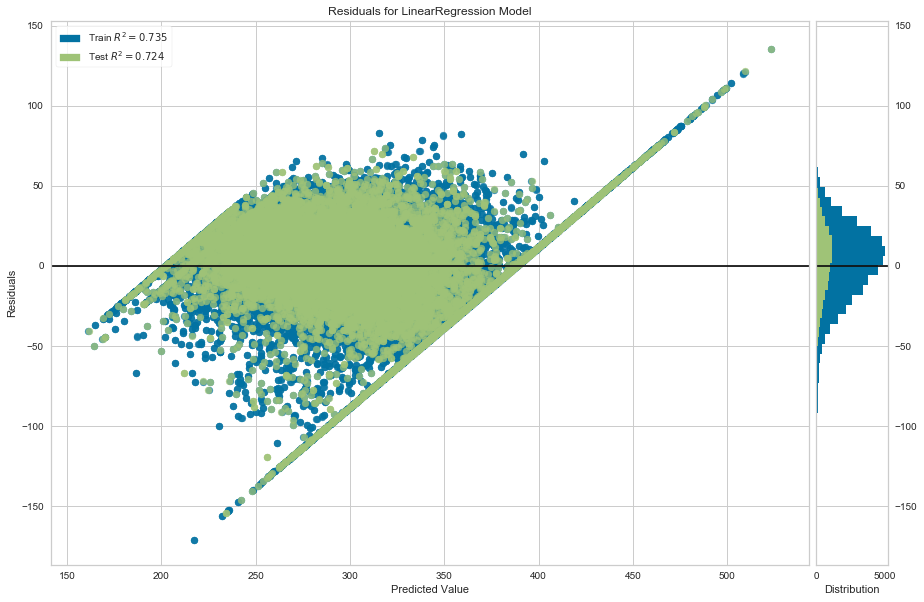

In [15]:
#Residuals Plot

# Instantiate the linear model and visualizer
model = LinearRegression() 
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(figsize=(18, 18)) 

## Ridge Regresson

In [16]:
#RIDGE Regression
model = Ridge(alpha=100).fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Ridge Regression Train: ', model.score(X_train, y_train))

print('\nR2: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Ridge Regression Train:  0.7332445927283624

R2:  0.7213369828790331
Explained Variance:  0.7213404119099913
Max Error:  156.74789605498546
mean_squared_log_error :  0.008004817363411248

MAE: 20.815673679179415   MSE: 772.8650295604017   RMSE: 27.80045016830486


## Lasso Regression

In [17]:
from sklearn import linear_model
model = linear_model.Lasso(alpha=0.1).fit(X_train, y_train)
y_pred = model.predict(X_test)

print('Lasso Regression Train: ', model.score(X_train, y_train))

print('\nR2: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Lasso Regression Train:  0.7321836469818693

R2:  0.7203265528925324
Explained Variance:  0.7203295301547064
Max Error:  152.90565891429074
mean_squared_log_error :  0.00803614897818317

MAE: 20.86794355488687   MSE: 775.6674322956256   RMSE: 27.850806672260422


## SVR

In [18]:
# from sklearn.svm import LinearSVR
# model = LinearSVR(random_state=0).fit(X_train, y_train)

# y_pred = model.predict(X_test)

# print('SVR Train: ', model.score(X_train, y_train))

# print('\nR2: ', model.score(X_test, y_test))
# print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
# print('Max Error: ', metrics.max_error(y_test, y_pred))
# print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

# print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
#       '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
#       '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

## Polynomial Regression

In [ ]:
# From https://muthu.co/simple-example-of-polynomial-regression-using-python/
# OVER 3rd order sucks   # OVER 6th ORDER WILL MELT CPU
nth_order = 2
model = make_pipeline(PolynomialFeatures(nth_order), LinearRegression())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print('\nR2: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
# OVER 3rd order sucks  # OVER 6th ORDER WILL MELT CPU
# Residuals Plot  # Instantiate the model and visualizer
nth_order = 2
model = make_pipeline(PolynomialFeatures(nth_order), LinearRegression())
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(figsize=(18, 18)) 

### Decision Tree Regression

In [19]:
# Decision Tree
model = DecisionTreeRegressor(random_state=0, )
# fit the regressor with X and Y data 
model.fit(X_train, y_train)

y_pred = model.predict(X_test) 

print('R2 Train: ', model.score(X_train, y_train))

print('\nR2 Test: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 Train:  1.0

R2 Test:  0.9874264318714674
Explained Variance:  0.9874288687557784
Max Error:  99.60563015501702
mean_squared_log_error :  0.00041057332738844845

MAE: 1.6364030485647942   MSE: 34.87248219637148   RMSE: 5.905292727407463


In [20]:
model.feature_importances_

array([9.76135417e-04, 3.24484277e-05, 3.68763798e-03, 6.58281173e-04,
       4.39113701e-02, 4.79354680e-02, 2.77212120e-01, 4.22357275e-02,
       1.19275997e-02, 1.31960554e-01, 4.23182242e-04, 1.78108819e-02,
       6.15133849e-04, 2.11674057e-04, 2.30249883e-02, 2.72560858e-01,
       1.20042262e-05, 6.22967946e-04, 3.66174961e-05, 4.45521317e-04,
       1.58673592e-03, 7.56605595e-04, 2.05506280e-04, 4.79501429e-04,
       1.89403773e-02, 4.94696858e-02, 6.43006096e-04, 1.05855325e-04,
       1.23209490e-02, 3.91906061e-02])

### Random Forrest Regression

In [21]:
# Random Forrest
model = RandomForestRegressor(n_estimators=10, min_samples_leaf=3, n_jobs=-1, random_state=0) 
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print('R2 Train: ', model.score(X_train, y_train))

print('\nR2 Test: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 Train:  0.9915715734893144

R2 Test:  0.9774626183073895
Explained Variance:  0.977463181963806
Max Error:  132.3796452541044
mean_squared_log_error :  0.0006976994913822444

MAE: 4.417389763283327   MSE: 62.50687424557746   RMSE: 7.906128903931269


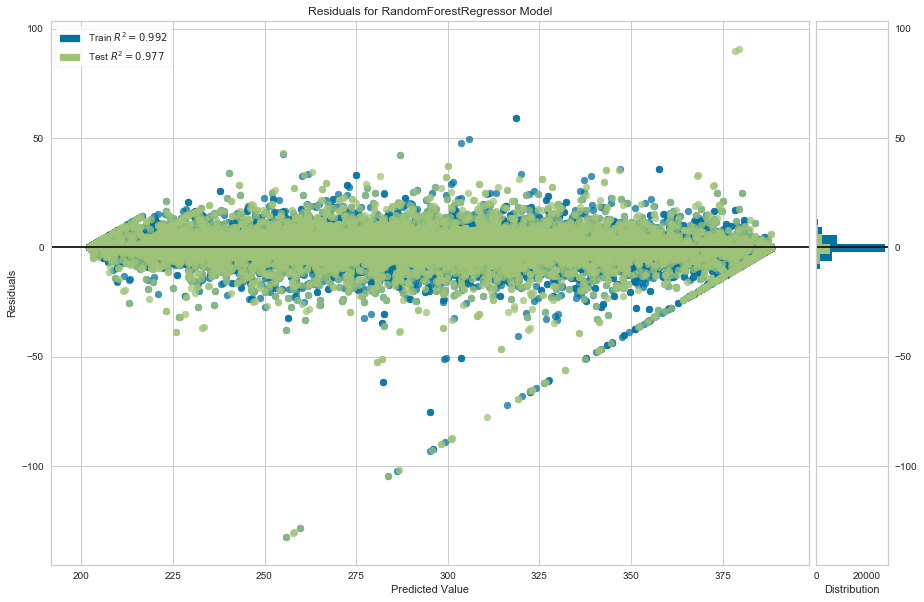

In [22]:
# Residuals Plot   # Instantiate the model and visualizer
model = RandomForestRegressor(n_estimators=10, min_samples_leaf=3, n_jobs=-1, random_state=0) 
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(figsize=(18, 18)) 

## MLP Regressor

In [27]:
# https://www.machinelearningtutorial.net/2017/01/28/python-scikit-simple-function-approximation/
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(alpha=0.01, hidden_layer_sizes = (30,), max_iter = 1000,
                 activation = 'relu', learning_rate = 'adaptive', random_state=0, verbose = 'True')  
model.fit(X_train, y_train)

pred_y = model.predict(X_test)

print('MLP Regression Train: ', model.score(X_train, y_train))

print('\nR2: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 3679.97061083
Iteration 2, loss = 1042.60173396
Iteration 3, loss = 785.43722329
Iteration 4, loss = 626.73925185
Iteration 5, loss = 545.32243350
Iteration 6, loss = 498.87639997
Iteration 7, loss = 472.23947238
Iteration 8, loss = 451.52570087
Iteration 9, loss = 437.82446515
Iteration 10, loss = 427.22297340
Iteration 11, loss = 415.95934341
Iteration 12, loss = 406.94745262
Iteration 13, loss = 398.35006890
Iteration 14, loss = 391.39865581
Iteration 15, loss = 384.81451722
Iteration 16, loss = 377.52331760
Iteration 17, loss = 371.46588786
Iteration 18, loss = 366.72203843
Iteration 19, loss = 362.49715860
Iteration 20, loss = 361.62182395
Iteration 21, loss = 353.22416532
Iteration 22, loss = 351.04100167
Iteration 23, loss = 347.48298726
Iteration 24, loss = 344.88252168
Iteration 25, loss = 341.78699860
Iteration 26, loss = 339.41884967
Iteration 27, loss = 337.93822426
Iteration 28, loss = 335.18796670
Iteration 29, loss = 332.46009301
Iteration 30, loss = 

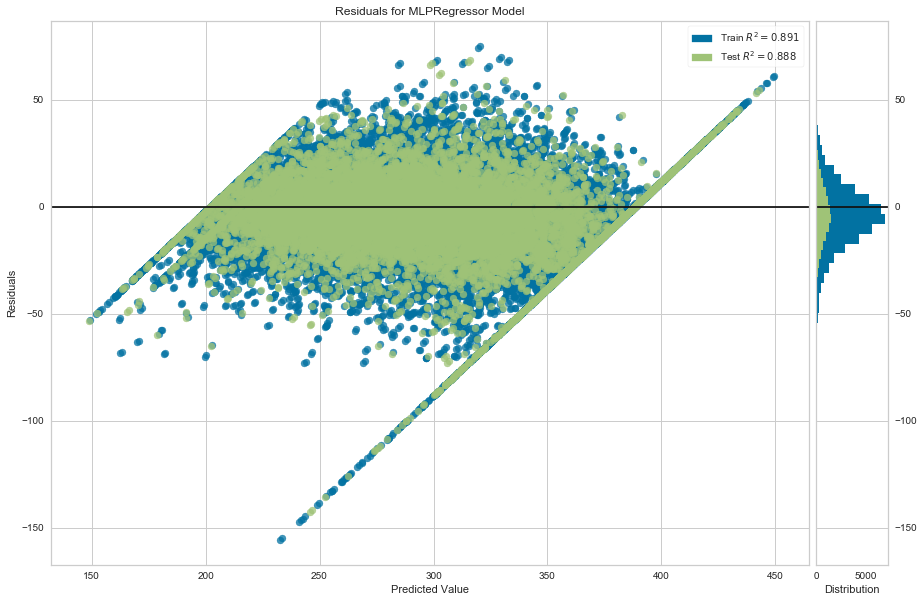

In [28]:
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(figsize=(18, 18)) 

## KNNRegressor

In [23]:
from sklearn import neighbors
model = neighbors.KNeighborsRegressor(n_neighbors = 5)
model.fit(X_train, y_train)  #fit the model
y_pred=model.predict(X_test)

print('R2 Train: ', model.score(X_train, y_train))

print('\nR2 Test: ', model.score(X_test, y_test))
print('Explained Variance: ', metrics.explained_variance_score(y_test, y_pred))
print('Max Error: ', metrics.max_error(y_test, y_pred))
print('mean_squared_log_error : ', metrics.mean_squared_log_error(y_test, y_pred))

print('\nMAE:', metrics.mean_absolute_error(y_test, y_pred),
      '  MSE:', metrics.mean_squared_error(y_test, y_pred),  
      '  RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

R2 Train:  0.8711270569124021

R2 Test:  0.7846781799080285
Explained Variance:  0.7848619869287683
Max Error:  182.86614269759878
mean_squared_log_error :  0.006515564293191064

MAE: 16.20558946345028   MSE: 597.1897762742624   RMSE: 24.43746665009003


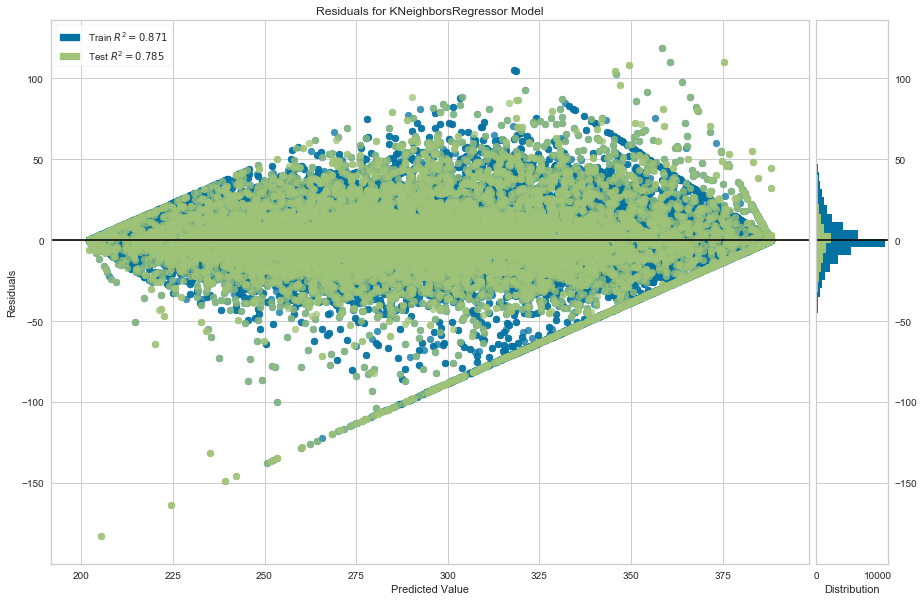

In [24]:
visualizer = ResidualsPlot(model, size=(1080, 720))

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show(figsize=(18, 18)) 